In [40]:
# Importamos paquetes
import os 
import folium
from folium import plugins
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString
import multiprocessing
import pickle

In [41]:
# # Coordenadas de Evanston, Illinois, USA
# m = folium.Map(location=[42.044770, -87.688531], crs = "EPSG3857")
# # m = folium.Map(location=[42.044770, -87.688531], crs = "EPSG3857", tiles = "CartoDB Positron") # Le ponemos ese tiles porque es sobrio. Si se lo quitamos añade mucha más info chingona
# # Usamos el Sistemas de referencia de coordenadas EPSG3857 por que es el más común para mapas en línea (O eso decía la librería del paquete)

# # Ahora vamos a definir los límites del mapa con las coordenadas suroeste y noreste
# m.fit_bounds([[42.019114, -87.711114], [42.071474, -87.679502]])

# # Visualizamos un mapa gomelo
# m

In [42]:
# Ahora vamos a importar la información que nos subió Nacho
# Primero empezamos con los .csv
parcels = pd.read_csv('./data/evanston_parcel_data.csv')
parcels.info()

#extract geo data from parcels
polygon_geom = []
for i in range(len(parcels.index)):
    p = Point(parcels.loc[i,'Longitude'], parcels.loc[i,'Latitude'])
    polygon_geom.append(p)

aux_df = gpd.GeoDataFrame(index=parcels.index, crs = {'init': 'epsg:4326'}, geometry = polygon_geom)
parcels = gpd.GeoDataFrame(parcels).merge(aux_df, left_index = True, right_index = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22339 entries, 0 to 22338
Data columns (total 61 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   PIN                                              22339 non-null  int64  
 1   Property Class                                   22339 non-null  int64  
 2   Tax Year                                         22339 non-null  int64  
 3   Neighborhood Code                                22339 non-null  int64  
 4   Land Square Feet                                 22339 non-null  int64  
 5   Town Code                                        22339 non-null  int64  
 6   Type of Residence                                13060 non-null  float64
 7   Apartments                                       13060 non-null  float64
 8   Wall Material                                    13060 non-null  float64
 9   Roof Material               

In [43]:
# Luego cogemos todos los archivos que terminen en .zip
main_data_list = []
for i in os.listdir('./data'): 
    if 'zip' in i:
        main_data_list.append(i)
# add all the files to a dictionary

# main_data -> m_d
m_d = {}
for i in main_data_list:
    m_d[i.replace('.zip', '')] = gpd.read_file('zip://' + os.getcwd() + '/data/' + i)

In [44]:
# Quiero arreglar estos bichos
[print(i,":", m_d[i].crs) for i in m_d.keys()]  

cblock : None
ctract : None
El Lines : epsg:4019
El Stations : epsg:4019
evanston : None
Lake Michigan : epsg:4019
Major Roads : epsg:4019
Metra Stops : epsg:4019
Rail Lines : epsg:4019


[None, None, None, None, None, None, None, None, None]

In [45]:
# Suponemos que los que no tienen sistema de coordenadas son también EPSG4019
for i in m_d.keys():
    if m_d[i].crs is None:
        m_d[i].set_crs(epsg = 4019, inplace = True)
        m_d[i].to_crs({'init': 'epsg:4326'}, inplace = True) 
    # Adicionalmente, el sistema de coordenadas que matchea con la proyección que hicimos arriba es EPSG4326
    else:
        m_d[i].to_crs({'init': 'epsg:4326'}, inplace = True) 

In [46]:
[print(i,":", m_d[i].crs) for i in m_d.keys()]  

cblock : +init=epsg:4326 +type=crs
ctract : +init=epsg:4326 +type=crs
El Lines : +init=epsg:4326 +type=crs
El Stations : +init=epsg:4326 +type=crs
evanston : +init=epsg:4326 +type=crs
Lake Michigan : +init=epsg:4326 +type=crs
Major Roads : +init=epsg:4326 +type=crs
Metra Stops : +init=epsg:4326 +type=crs
Rail Lines : +init=epsg:4326 +type=crs


[None, None, None, None, None, None, None, None, None]

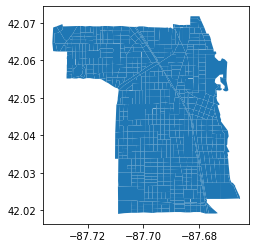

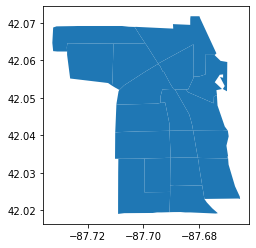

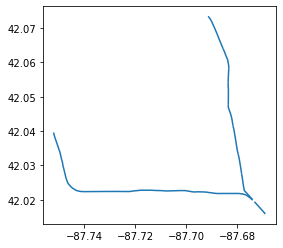

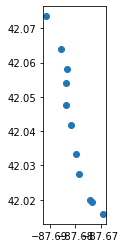

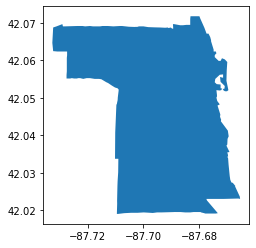

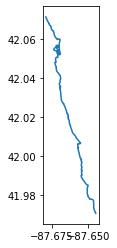

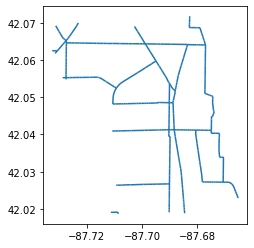

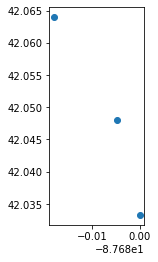

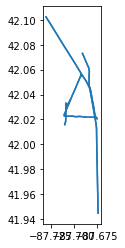

In [47]:
[m_d[i].plot() for i in m_d.keys()]  

In [48]:
trenes = []
for i in range(len(m_d["Rail Lines"]["geometry"])):
    x1, y1 = m_d["Rail Lines"]["geometry"][i].coords.xy
    x1 = [i for i in x1]
    y1 = [i for i in y1]
    trenes.append(list(zip(y1, x1)))

principales = []
for i in range(len(m_d["Major Roads"]["geometry"])):
    x1, y1 = m_d["Major Roads"]["geometry"][i].coords.xy
    x1 = [i for i in x1]
    y1 = [i for i in y1]
    principales.append(list(zip(y1, x1)))

metro = []
for i in range(len(m_d['El Lines']["geometry"])):
    x1, y1 = m_d['El Lines']["geometry"][i].coords.xy
    x1 = [i for i in x1]
    y1 = [i for i in y1]
    metro.append(list(zip(y1, x1)))

estaciones_metro = []
for i in range(len(m_d['El Stations']["geometry"])):
    x1, y1 = m_d['El Stations']["geometry"][i].coords.xy
    x1 = [i for i in x1]
    y1 = [i for i in y1]
    estaciones_metro.append(list(zip(y1, x1)))


In [49]:
a_data_list = []
for i in os.listdir('./aux_data'): 
    if 'zip' in i:
        a_data_list.append(i)
a_d = {}
for i in a_data_list:
    a_d[i.replace('.zip', '')] = gpd.read_file('zip://' + os.getcwd() + '/aux_data/' + i)

In [50]:
for i in a_d.keys():
        a_d[i] = a_d[i].to_crs({'init': 'epsg:4326'})

In [51]:
# # Coordenadas de Evanston, Illinois, USA
# m = folium.Map(location=[42.044770, -87.688531], crs = "EPSG3857", tiles = "CartoDB Positron") # Le ponemos ese tiles porque es sobrio. Si se lo quitamos añade mucha más info chingona
# # Usamos el Sistemas de referencia de coordenadas EPSG3857 por que es el más común para mapas en línea (O eso decía la librería del paquete)

# # Ahora vamos a definir los límites del mapa con las coordenadas suroeste y noreste
# m.fit_bounds([[42.019114, -87.711114], [42.071474, -87.679502]])

# style1 = {'fillColor': '#228B22', 'fillOpacity': 0.1, 'color': '#228B22'}
# style2 = {'fillColor': '#F0CE47', 'fillOpacity': 0.9, 'color': '#F0CE47'}

# folium.GeoJson(
#     a_d['Beaches'],
#     name = 'Playas',
#     style_function=lambda x:style2
# ).add_to(m)


# folium.GeoJson(
#     m_d["cblock"],
#     name = 'Census blocks',
#     style_function=lambda x:style1
# ).add_to(m)

# folium.PolyLine(principales,
#                 name = 'Vias principales',
#                 popup = 'Vias principales',
#                 color = 'black').add_to(m)

# folium.PolyLine(trenes,
#                 name = 'Lineas del ferrocarril',
#                 popup = 'Lineas del ferrocarril',
#                 color = 'red',
#                 dash_array = '5').add_to(m)

# folium.PolyLine(metro,
#                 name = 'Lineas del metro (EL)',
#                 popup = 'Lineas del metro (EL)',
#                 color = 'blue',
#                 dash_array = '5').add_to(m)

# for i in range(0, len(estaciones_metro)):
#     folium.Marker([estaciones_metro[i][0][0], estaciones_metro[i][0][1]], 
#     popup = "Estacion del metro",
#     icon = folium.Icon(color = 'lightgray', icon = 'train', prefix = 'fa')
#     ).add_to(m)
 

# folium.LayerControl().add_to(m)

# # Visualizamos un mapa gomelo
# m

**b) Match the parcel data to the block level file and calculate average assessment
values and building area to floor area at the block level.**

In [52]:
m_d = {**m_d, **a_d}
del(a_d, a_data_list)

In [53]:
# find parcels outside of the city (defined as census tracts)
aux_0 = [i.replace('.', '') if '.' in i else i + '00' for i in m_d['tracts'].name10.unique()]
aux_1 = [str(i) for i in parcels['Census Tract'].unique()]
missing = [int(i) for i in [i for i in aux_1 if i not in aux_0]]

parcels = parcels.loc[[False if i in missing else True for i in parcels['Census Tract']],:]

#restore index
parcels.reset_index(drop = True, inplace = True)

In [54]:
# find blocks outside the city (same as above )
aux_1 = [str(i) for i in m_d['cblock'].TRACT2000.unique()]
missing = [str(i) for i in [i for i in aux_1 if i not in aux_0]]
m_d['cblock'] = m_d['cblock'].loc[[False if i in missing else True for i in m_d['cblock'].TRACT2000],:] 
m_d['cblock'].reset_index(drop = True, inplace = True)

In [55]:
# correct dtype
m_d['cblock']['TRACT2000'] = m_d['cblock']['TRACT2000'].apply(int)

In [56]:
parcels.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 22322 entries, 0 to 22321
Data columns (total 62 columns):
 #   Column                                           Non-Null Count  Dtype   
---  ------                                           --------------  -----   
 0   PIN                                              22322 non-null  int64   
 1   Property Class                                   22322 non-null  int64   
 2   Tax Year                                         22322 non-null  int64   
 3   Neighborhood Code                                22322 non-null  int64   
 4   Land Square Feet                                 22322 non-null  int64   
 5   Town Code                                        22322 non-null  int64   
 6   Type of Residence                                13044 non-null  float64 
 7   Apartments                                       13044 non-null  float64 
 8   Wall Material                                    13044 non-null  float64 
 9   Roof Mate

In [57]:
# # Esto toca correrlo en linux porque o sino todo se va a la monda
# # use multicore to do the separation:
# # each core gets a part of the parcels (by tract)
# # each core also gets the polygons corresponding to the blocks on that tract
# # they have to keep the correct indexing to re assamble the data

# # create a list [blocks, parcels] whithin a tract

# complete_list = []

# for i in m_d['cblock']['TRACT2000'].unique():
#     complete_list.append([
#         m_d['cblock'].loc[m_d['cblock']['TRACT2000'].eq(i), ['geometry', 'ID']],
#         parcels.loc[parcels['Census Tract'].eq(i), ['geometry']] 
#     ])

# def check_where(parcel, tract):
#     for i in tract.index: 
#         if tract.loc[i,'geometry'].contains(parcel):
#             return tract.loc[i, 'ID']
#     return None

# def multiprocessing_func(a_list):
#     # unpack the list:
#     tract = a_list[0]
#     par = a_list[1]
#     par['result'] = None
#     for i in par.index:
#         par.loc[i, 'result'] = check_where(par.loc[i,'geometry'],tract)
#     q.put(par.loc[:,['result']])
    
# if __name__ == '__main__':
#     q = multiprocessing.Queue()  
#     processes = []
#     for i in complete_list:
#         p = multiprocessing.Process(target=multiprocessing_func, 
#                                     args=(i,))
#         processes.append(p)
#         p.start()
    
    
#     resultado = []  
#     counter = 1  
#     for process in processes:
#         print(counter)
#         a = q.get()
#         resultado.append(a)
#         counter += 1
#     print("Terminamos")
#     for process in processes:
#         process.join()

# # now join the results
# marker = True
# for i in resultado:
#     if marker:
#         marker = False
#         result = i
#     else:
#         result = result.append(i)
    

In [58]:

# result = result.sort_index()
# result.rename(columns = {"result":"block"}, inplace = True)
# parcels = parcels.merge(result, left_index = True, right_index = True)

In [59]:
# # there are 76 parcels that don't have a block, for those we have to search in all the blocks
# sum([i is None for i in parcels.block])

In [60]:
# a_list = [m_d['cblock'].loc[:, ['geometry', 'ID']] , parcels.loc[[i is None for i in parcels.block], ['geometry']]]

# tract = a_list[0]
# par = a_list[1]
# par['result'] = None
# for i in par.index:
#     par.loc[i, 'result'] = check_where(par.loc[i,'geometry'],tract)


In [61]:
# parcels.loc[[i is None for i in parcels.block], ['block']] = par['result']

In [62]:
# # now we have to calculate at block level average assessment values and building area to floor area at the block level

# parcels['Assessed Value'].isna().sum()

# # there are a few missing values that will be ignored (they are not much compared to the sample)


In [63]:
with open('./aux_data/parcels_melo.pkl', "rb") as f: 
    parcels = pickle.load(f)
# for the ratio building area to floor area there are quite a lot of parcels that do not have buildings on them, therefore, those are not taken into account when making this ratio 

# create new variable with this ratio 

parcels['ratio'] = parcels['Building Square Feet']/parcels['Land Square Feet']

In [64]:
parcels.groupby('block').mean().loc[:,['Assessed Value', 'ratio']]

,Assessed Value,ratio
block,,
39294,485841.379310,0.316965
39295,305691.463415,0.441226
39296,808594.545455,0.362263
39304,357773.962264,0.496605
39305,757390.000000,0.537446
...,...,...
40066,302892.083333,0.228732
40067,359519.423077,0.279256
40068,421614.000000,0.262009


In [71]:
m_d['cblock'].merge(parcels.groupby('block').mean().loc[:,['Assessed Value', 'ratio']], right_index = True, left_on = "ID")

,SP_ID,ID,FIPSSTCO,TRACT2000,BLOCK2000,STFID,geometry,Assessed Value,ratio
1,39293,39294,17031,808702,1001,170318087021001,"POLYGON ((-87.67756 42.05503, -87.68006 42.055...",485841.379310,0.316965
2,39294,39295,17031,808702,1002,170318087021002,"POLYGON ((-87.68006 42.05393, -87.68206 42.053...",305691.463415,0.441226
3,39295,39296,17031,808702,1003,170318087021003,"POLYGON ((-87.68006 42.05393, -87.68006 42.055...",808594.545455,0.362263
11,39303,39304,17031,808702,1011,170318087021011,"POLYGON ((-87.68026 42.05203, -87.68216 42.052...",357773.962264,0.496605
12,39304,39305,17031,808702,1012,170318087021012,"POLYGON ((-87.67766 42.05203, -87.68026 42.052...",757390.000000,0.537446
...,...,...,...,...,...,...,...,...,...
770,40065,40066,17031,810302,3005,170318103023005,"POLYGON ((-87.69496 42.02743, -87.69496 42.026...",302892.083333,0.228732
771,40066,40067,17031,810302,3006,170318103023006,"POLYGON ((-87.69496 42.02656, -87.69271 42.026...",359519.423077,0.279256
772,40067,40068,17031,810302,3007,170318103023007,"POLYGON ((-87.69661 42.02651, -87.69506 42.026...",421614.000000,0.262009
773,40068,40069,17031,810302,3008,170318103023008,"POLYGON ((-87.69661 42.02651, -87.69666 42.024...",445302.400000,0.228246


In [75]:
cblock = m_d['cblock'].merge(parcels.groupby('block').mean().loc[:,['Assessed Value', 'ratio']], right_index = True, left_on = "ID")
cblock.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 668 entries, 1 to 774
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   SP_ID           668 non-null    object  
 1   ID              668 non-null    int64   
 2   FIPSSTCO        668 non-null    object  
 3   TRACT2000       668 non-null    int64   
 4   BLOCK2000       668 non-null    object  
 5   STFID           668 non-null    object  
 6   geometry        668 non-null    geometry
 7   Assessed Value  668 non-null    float64 
 8   ratio           652 non-null    float64 
dtypes: float64(2), geometry(1), int64(2), object(4)
memory usage: 52.2+ KB


In [93]:
# Coordenadas de Evanston, Illinois, USA
m = folium.Map(location=[42.044770, -87.688531], crs = "EPSG3857", tiles = "CartoDB Positron") # Le ponemos ese tiles porque es sobrio. Si se lo quitamos añade mucha más info chingona
# Usamos el Sistemas de referencia de coordenadas EPSG3857 por que es el más común para mapas en línea (O eso decía la librería del paquete)

# Ahora vamos a definir los límites del mapa con las coordenadas suroeste y noreste
m.fit_bounds([[42.019114, -87.711114], [42.071474, -87.679502]])

style2 = {'fillColor': '#F0CE47', 'fillOpacity': 0.9, 'color': '#F0CE47'}

folium.GeoJson(
    m_d['Beaches'],
    name = 'Playas',
    style_function=lambda x:style2
).add_to(m)


folium.Choropleth(
    name = 'Building area to floor area ratio',
    geo_data = cblock,
    data = cblock,
    columns = ['ratio'],
    key_on = 'ID'
).add_to(m)

folium.PolyLine(principales,
                name = 'Vias principales',
                popup = 'Vias principales',
                color = 'black').add_to(m)

folium.PolyLine(trenes,
                name = 'Lineas del ferrocarril',
                popup = 'Lineas del ferrocarril',
                color = 'red',
                dash_array = '5').add_to(m)

folium.PolyLine(metro,
                name = 'Lineas del metro (EL)',
                popup = 'Lineas del metro (EL)',
                color = 'blue',
                dash_array = '5').add_to(m)

for i in range(0, len(estaciones_metro)):
    folium.Marker([estaciones_metro[i][0][0], estaciones_metro[i][0][1]], 
    popup = "Estacion del metro",
    icon = folium.Icon(color = 'lightgray', icon = 'train', prefix = 'fa')
    ).add_to(m)
 

folium.LayerControl().add_to(m)

# Visualizamos un mapa gomelo
m

IndexError: list index out of range

In [70]:
m_d['cblock']

,SP_ID,ID,FIPSSTCO,TRACT2000,BLOCK2000,STFID,geometry
0,39292,39293,17031,808702,1000,170318087021000,"POLYGON ((-87.67416 42.05503, -87.67756 42.055..."
1,39293,39294,17031,808702,1001,170318087021001,"POLYGON ((-87.67756 42.05503, -87.68006 42.055..."
2,39294,39295,17031,808702,1002,170318087021002,"POLYGON ((-87.68006 42.05393, -87.68206 42.053..."
3,39295,39296,17031,808702,1003,170318087021003,"POLYGON ((-87.68006 42.05393, -87.68006 42.055..."
4,39296,39297,17031,808702,1004,170318087021004,"POLYGON ((-87.67416 42.05503, -87.67436 42.054..."
...,...,...,...,...,...,...,...
770,40065,40066,17031,810302,3005,170318103023005,"POLYGON ((-87.69496 42.02743, -87.69496 42.026..."
771,40066,40067,17031,810302,3006,170318103023006,"POLYGON ((-87.69496 42.02656, -87.69271 42.026..."
772,40067,40068,17031,810302,3007,170318103023007,"POLYGON ((-87.69661 42.02651, -87.69506 42.026..."
773,40068,40069,17031,810302,3008,170318103023008,"POLYGON ((-87.69661 42.02651, -87.69666 42.024..."


In [68]:
m_d['Beaches']

,cartoname,date_creat,time_creat,globalid,greenwaysa,date_last_,time_last_,objectid,shape_star,shape_stle,geometry
0,South Boulevard Beach,None,None,{1CAACF98-EDE8-43BA-A1FA-EBCECBEB93F2},Yes,2018-03-13,20:03:57.000,5.0,125163.958252,1784.131161,"POLYGON ((-87.66723 42.02667, -87.66732 42.026..."
1,Lincoln Street Beach,2018-07-13,14:59:44.000,{3A5D687E-1D57-4221-A8E6-86AB3EFC832A},Yes,2018-07-13,15:01:49.000,322.0,185659.218750,1799.965373,"POLYGON ((-87.67354 42.06169, -87.67250 42.061..."
2,Clark Street Beach,None,None,{240871EA-6E84-43D0-AEEF-EB39D9E95235},Yes,2018-03-13,20:03:56.000,2.0,302738.387207,2252.796693,"POLYGON ((-87.67271 42.04805, -87.67314 42.047..."
3,Lee Street Beach,None,None,{C989E004-6E1B-45C1-82CC-FAAC2AB9660E},Yes,2018-03-13,20:04:00.000,4.0,140473.451416,1840.225878,"POLYGON ((-87.67014 42.03739, -87.67010 42.037..."
4,Lighthouse Landing Beach,None,None,{A4CED6E3-0C0D-4D83-87ED-6D15CB8191B4},Yes,2018-03-13,20:03:53.000,1.0,184794.951904,2173.043668,"POLYGON ((-87.67530 42.06389, -87.67530 42.063..."
5,Dog Beach,None,None,{A8BCC3DA-A721-42DC-B0C3-B6EF5EED9A99},Yes,2018-03-13,20:03:55.000,321.0,125162.625732,1821.489991,"POLYGON ((-87.67242 42.04609, -87.67243 42.046..."
6,Greenwood Street Beach,None,None,{5770E165-4414-4301-A0DE-324AB469B7B2},Yes,2020-06-15,18:03:33.000,3.0,216637.895752,3891.161202,"POLYGON ((-87.66933 42.04132, -87.66932 42.041..."
